# Toy MC for the ATLAS High Granularity Timing Detector

In [106]:
import ROOT
from ROOT import TCanvas, TGraph, gROOT
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import time 
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from array import array
from matplotlib.ticker import LinearLocator

### Constants

In [2]:
nr_of_channels = int(3.6 * 1e6)
channels_per_module = int(15*30)
total_modules = int(nr_of_channels/channels_per_module)
global_counter = 0

### Noise Generator Class:
This class takes in the parameters threshold and channel count (proportional to the number of interactions mu per bunch crossing) and calculates the mean number of channels activated by noise by calculating the probability mass that a part of the Gaussian distribution will be above the set average, and multiplies it with the total number of channels. The class has a function generate, which calculates a variation of the mean number of noise activated channels by drawing from a Poisson dist. with mean as parameter, and calculates how many of them are triggered during the small time window of 3.125ns (true value of them!) by drawing from a uniform dist. (0,1) for each number of noise activated channel and seeing how many are under 0.125 (3.125/25 = 0.125). Finally, it estimates the number of triggered channels in the small window by determining the number of channels triggered in one ns and multiplying by 3.125ns. This way, we have a true number of noise activated channels in the small window, and one that is estimated.

try different big time windows , eg 4*3.125, lines 25-26. Change value of *big_window*

In [3]:
class noise_generator:
    def __init__(self, threshold, channel_count): 
        global global_counter
        low = 0
        high = 1000
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", low, high)
        
        """Why divide with 2?? Why do we need a avg. value?"""
        #integrate normal dist. to get exact prob. above threshold and multiply with channel nr to get avg.
        self._mean = channel_count * noise.Integral(threshold, high)/noise.Integral(low, high) 
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)

    def generate(self):
        """The first return value is the exact number of noise activated channels in the small window and
            the second return value is the estimated number of noise activated channels in the small window. (estimated from large window)
            (both results are in small window, both results are noise above threshold)
            noise_exact, noise_est = noise.generate()"""
        # Large time window 25ns
        # Small time window 3.125ns
        prng = self._prng
        total = prng.Poisson(self._mean) # number of noise above threshold in large window in this run.
        
        narrow_exact = 0
        big_window = 4*3.125
        
        #narrow_exact = (np.random.rand(total) < 0.125).sum()  # 3.125/25 = 0.125
        #noise_per_time = (total - narrow_exact)/(25 - 3.125)
        
        narrow_exact = (np.random.rand(total) < 3.125/big_window).sum() # ex. 3.125/(3.125*4) big window of 4 times 3.125 
        noise_per_time = (total - narrow_exact)/(big_window - 3.125)
        
        estimate = 3.125 * noise_per_time
        return narrow_exact, estimate




 ### Signal Generator Class:
 This class takes the input parametes threshold and the real and guessed most probable peak voltage of the signal distribution (100mV when the sensors are new). It calculates the fraction of the Landau distribution that will be above the set threshold. It has a function generate, which takes in the paramter expected_count, that is, the estimated number of particles that will reach the detector (for mu=200 it is around 15k), then it determines a possible number of hits on the detector by drawing from a Poisson distribution around that parameter. Finally, for each calculated hit, it determines how many channels were triggered by signal from a particle by sampling a Landau distribution and checking how many of them are above the threshold. It returns the number of particles hitting the detector, and the number of signal-activated channels.

In [4]:
class signal_generator:
    def __init__(self, threshold, real_expected_voltage, guess_expected_voltage): # expected_voltage = expected peak voltage  (mu)
        global global_counter
        low = -100
        high = 1000
        self._threshold = threshold
        self._expected_voltage = real_expected_voltage
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (guess_expected_voltage, guess_expected_voltage/4), low, high)
        self.fraction_above = signal_func.Integral(threshold, high)/signal_func.Integral(low, high) #fraction of the function that is above threshold
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
    
    def generate(self, expected_count):
        """The paramater is the expected number of particles that reach the detector.
            The first return value is the number of particles that reached the detector and
            the second return value is the number of activated channels.
            signal_real_total, signal_above = signal.generate(30)"""
        prng = self._prng
        expected_voltage = self._expected_voltage
        threshold = self._threshold
        
        signal_count = prng.Poisson(expected_count)
        above_threshold_count = 0
        sigma = expected_voltage/4
        for i in range(signal_count):
            if prng.Landau(expected_voltage, sigma) > threshold: # 1/4 is just the refernce 25/100
                above_threshold_count += 1
        return signal_count, above_threshold_count
    

## Simulation function


In [5]:
def simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage):
    """For a number of BC, we get two lists: total_actual_signal_count and total_estimated_signal_count for each BC"""

    channel_count = nr_of_channels*ratio_of_channels_to_sample
    #avg_particles_reaching_detector = channel_count * signal_to_channel_count_ratio

    #generate the noise
    noise_gen = noise_generator(threshold, channel_count)
    #generate the signal
    signal_gen = signal_generator(threshold, peak_mpv_voltage, guess_mpv_voltage)

    result_true_signal_count = np.zeros(bunch_crossings)
    result_estimated_signal_count = np.zeros(bunch_crossings)
    error_estimation = 0
    signal_fraction_above = signal_gen.fraction_above
    deviation_from_true = np.zeros(bunch_crossings)
    for BC in range(bunch_crossings):
        # both results are in small window, both are noise above threshold
        noise_exact, noise_est = noise_gen.generate()

        # The paramater is the expected number of particles that reach the detector.
        # The first return value is the number of particles that reached the detector and 
        # the second return value is the number of activated channels.
        total_actual_signal, signal_above = signal_gen.generate(expected_count)

        # from the total activations, estimate how much was produced by actual signal
        total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
        #print("\nBunch Crossing %d:" %(BC+1))
        #print("Signal- and noise-activated channels: %d" %(total_activations))
        #print ("Noise-activated channels: %d" %(noise_exact))
        #total real activations minus estimation of signal, then divide with the prob. mass for Landau to be above threshold
        total_signal_est = (total_activations - noise_est)/signal_fraction_above 

        # assign the results
        result_true_signal_count[BC] = total_actual_signal #exact count in the small window
        result_estimated_signal_count[BC] = total_signal_est #estimated count 
        
        deviation_from_true [BC] = total_signal_est - total_actual_signal
        
    return result_true_signal_count, result_estimated_signal_count, deviation_from_true/bunch_crossings



In [7]:
"""Parameters for the simulation"""
peak_mpv_voltage = 100 #mV, mpv: most probable value
guess_mpv_voltage = 100 #mV
mu = 200
"""exp number of particles on detector proportional to mu, try also non-linear relationship as in christian's plot """
expected_count = (15*1e3/200)*mu #expected number of particles reaching the HGTD for mu=200, no more than 20k
bunch_crossings = 1000
ratio_of_channels_to_sample = 1
print("Expected count: %f" %expected_count)

Expected count: 15000.000000


 ### Graphical estimation of best threshold with regards to deviation from the true signal 


Deviation for threshold 20.000000: 0.000082
Deviation for threshold 20.428571: 0.000072
Deviation for threshold 20.857143: 0.000025
Deviation for threshold 21.285714: 0.000177
Deviation for threshold 21.714286: 0.000235
Deviation for threshold 22.142857: 0.000063
Deviation for threshold 22.571429: 0.000056
Deviation for threshold 23.000000: 0.000080
Deviation for threshold 23.428571: 0.000002
Deviation for threshold 23.857143: 0.000066
Deviation for threshold 24.285714: 0.000001
Deviation for threshold 24.714286: 0.000019
Deviation for threshold 25.142857: 0.000029
Deviation for threshold 25.571429: 0.000018
Deviation for threshold 26.000000: 0.000000
Deviation for threshold 26.428571: 0.000006
Deviation for threshold 26.857143: 0.000066
Deviation for threshold 27.285714: 0.000014
Deviation for threshold 27.714286: 0.000055
Deviation for threshold 28.142857: 0.000024
Deviation for threshold 28.571429: 0.000052
Deviation for threshold 29.000000: 0.000058
Deviation for threshold 29.42857

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


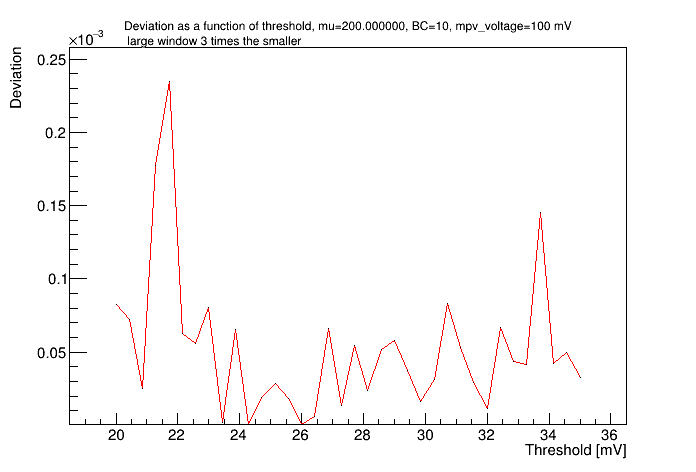

In [45]:
min_threshold = 20 #mV
max_threshold = 35 #mV
threshold_array = np.linspace(min_threshold,max_threshold,36)
total_deviation= np.zeros(len(threshold_array))
iteration = 0
start_time = time.time()

for threshold in threshold_array:
    
    true_signal, estimated_signal, dev = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage)
    
    """Get the total deviation from the total simulated signals vs the expected signals.
        Returns both the total deviation as a positive number"""
    true_signal_sum = true_signal.sum()
    if true_signal_sum == 0:
        deviation = 0
    deviation = abs( estimated_signal.sum() / true_signal_sum -1)
    total_deviation[iteration] = deviation
    print("Deviation for threshold %f: %f" %(threshold, total_deviation[iteration]))
    iteration = iteration+1

best = find_best_threshold(total_deviation)
print("Best threshold: %d"%best)

c1 = TCanvas( 'c1', 'Graph', 200, 10, 700, 500 )
#c1.SetLogy()

g = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation.astype(np.double))
g.SetTitle( "#splitline{Deviation as a function of threshold, mu=%f, BC=%d, mpv_voltage=%d mV}{\n large window 3 times the smaller}"  %(mu, bunch_crossings, peak_mpv_voltage))
g.GetXaxis().SetTitle( 'Threshold [mV]' )
g.GetYaxis().SetTitle( 'Deviation' )
g.GetYaxis().SetRange(0,10);
g.SetLineColor(2)
g.Draw(); 
c1.Draw()
c1.Modified()
c1.Update();
print("CPU time: %s seconds" % (time.time() - start_time))

### Finer search for the best threshold: exact value
Use nr_of_simulations?? Maybe redundant?


Deviation for threshold 20.000000: 0.000093
Mean dev for threshold 20.000000: 0.013970
Std for threshold 20.000000: 0.080929

Deviation for threshold 21.000000: 0.000045
Mean dev for threshold 21.000000: 0.006725
Std for threshold 21.000000: 0.055388

Deviation for threshold 22.000000: 0.000030
Mean dev for threshold 22.000000: 0.004460
Std for threshold 22.000000: 0.031321

Deviation for threshold 23.000000: 0.000013
Mean dev for threshold 23.000000: 0.001991
Std for threshold 23.000000: 0.023407

Deviation for threshold 24.000000: 0.000003
Mean dev for threshold 24.000000: 0.000418
Std for threshold 24.000000: 0.018009

Deviation for threshold 25.000000: 0.000016
Mean dev for threshold 25.000000: 0.002338
Std for threshold 25.000000: 0.015376

Deviation for threshold 26.000000: 0.000013
Mean dev for threshold 26.000000: 0.001956
Std for threshold 26.000000: 0.013084

Deviation for threshold 27.000000: 0.000004
Mean dev for threshold 27.000000: 0.000599
Std for threshold 27.000000: 0

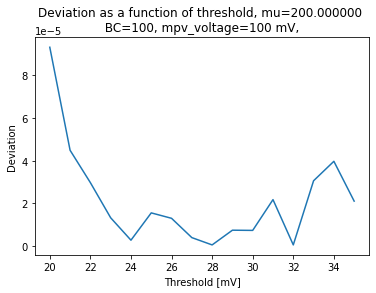

Best threshold with dev:
Size of array: 2
[28. 32.]
Best threshold with mean:
Size of array: 1
best threshold: 28.000000


Warning in <TCanvas::Constructor>: Deleting canvas with same name: Deviation over Threshold
Info in <TCanvas::Print>: pdf file Deviation_Over_Threshold.pdf has been created


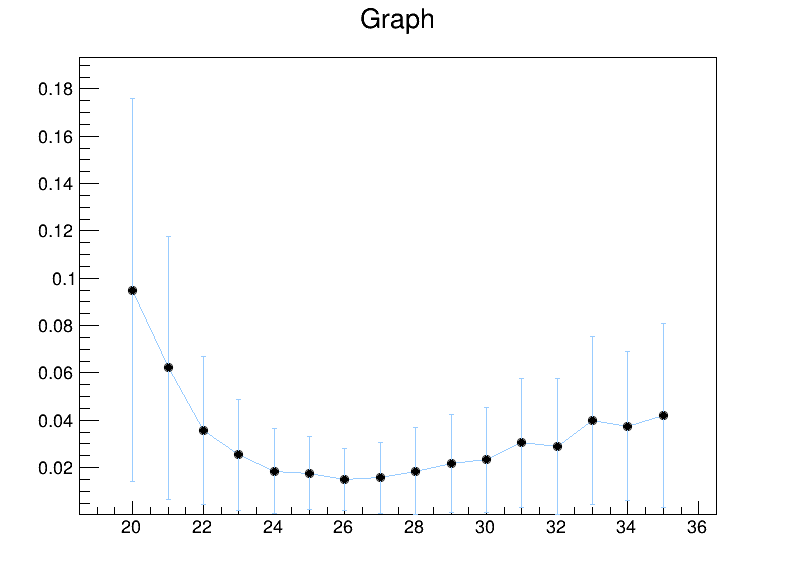

In [20]:
min_threshold = 20#mV
max_threshold = 35#mV
threshold_array = np.linspace(min_threshold,max_threshold,16)
total_deviation= np.zeros(len(threshold_array))
iteration = 0
start_time = time.time()
dev = np.zeros(len(threshold_array))
mean_values = []
mean_values_with_std = []
std_values = []
val = []
for threshold in threshold_array:
    
    true_signal, estimated_signal, dev_per_BC = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage)
    
    """Get the total deviation from the total simulated signals vs the expected signals.
        Returns both the total deviation as a positive number"""

    true_signal_sum = true_signal.sum()
    if true_signal_sum == 0:
        deviation = 0
    deviation = abs( estimated_signal.sum() / true_signal_sum -1)
    total_deviation[iteration] = deviation
    print("\nDeviation for threshold %f: %f" %(threshold, total_deviation[iteration]))
    
    
    mean_values.append(abs(np.mean(dev_per_BC)))
    mean_values_with_std.append(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
    print ("Mean dev for threshold %f: %f" %(threshold, mean_values[iteration]))
    std_values.append(np.std(dev_per_BC))
    print ("Std for threshold %f: %f" %(threshold, std_values[iteration]))
    val.append (abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
    iteration = iteration+1

plt.plot(threshold_array, total_deviation)
#plt.yscale("log")
plt.xlabel("Threshold [mV]")
plt.ylabel("Deviation")
plt.title ('Deviation as a function of threshold, mu=%f \n BC=%d, mpv_voltage=%d mV, ' %(mu, bunch_crossings, peak_mpv_voltage))
plt.show()
#calculate best threshold
print("Best threshold with dev:")
find_best_threshold(total_deviation)
print("Best threshold with mean:")
find_best_threshold(mean_values)


#create x,y values and corresponding errors
threshold_error = []
for i in range (len(threshold_array)):
    threshold_error.append(0)

n = len(threshold_array);
x  = array( 'f', threshold_array )
ex = array( 'f', threshold_error)
y  = array( 'f', mean_values_with_std)
ey = array( 'f', std_values) 

deviation_graph = ROOT.TGraphErrors( n, x, y, ex, ey )

#create Canvas
Canvas = ROOT.TCanvas("Deviation over Threshold", "Difference in counts", 800, 600)
#Set different plot settings 
deviation_graph.SetMarkerStyle(20)
deviation_graph.SetLineColor(ROOT.kAzure-9)
deviation_graph.SetFillColor(ROOT.kAzure-14)
deviation_graph.Draw()

#Draw and export final Histo
Canvas.Draw()
Canvas.SaveAs("Deviation_Over_Threshold.pdf")

### Function to find best threshold 

In [16]:
def find_best_threshold (total_deviation):
    """Input parameter is a list of the deviation for each threshold, returns the best threshold with lowest deviation"""
    
    total_deviation = [round(num, 6) for num in total_deviation]

    best_array_indexes = [i for i, x in enumerate(total_deviation) if x == min(total_deviation)]
    print("Size of array: %d" %len(best_array_indexes))
    best_thresholds_array = np.zeros(len(best_array_indexes))
    if len(best_array_indexes)==1:
         print("best threshold: %f" %(threshold_array[best_array_indexes[0]]))
         return threshold_array[best_array_indexes[0]]
    
    else: 
        for i in range (len(best_array_indexes)):
            best_thresholds_array[i] = threshold_array[best_array_indexes[i]]
        print (best_thresholds_array)
        return sum(best_thresholds_array)/len(best_thresholds_array)

### Study how the threshold and the deviation changes with worsening of the sensor with time because of radiation damage



Simulations for mpv peak voltage 25mV

Mean dev for threshold 5.000000: 0.383580
Std for threshold 5.000000: 5.754317
Mean dev for threshold 6.000000: 0.211281
Std for threshold 6.000000: 6.065065
Mean dev for threshold 7.000000: 0.221925
Std for threshold 7.000000: 4.031743
Mean dev for threshold 8.000000: 0.043671
Std for threshold 8.000000: 3.020617
Mean dev for threshold 9.000000: 0.021089
Std for threshold 9.000000: 3.103177
Mean dev for threshold 10.000000: 0.075667
Std for threshold 10.000000: 2.357126
Mean dev for threshold 11.000000: 0.281308
Std for threshold 11.000000: 2.060555
Mean dev for threshold 12.000000: 0.021821
Std for threshold 12.000000: 1.363102
Mean dev for threshold 13.000000: 0.092177
Std for threshold 13.000000: 1.025835
Mean dev for threshold 14.000000: 0.004360
Std for threshold 14.000000: 0.806637
Mean dev for threshold 15.000000: 0.101279
Std for threshold 15.000000: 0.592461
Mean dev for threshold 16.000000: 0.070680
Std for threshold 16.000000: 0.46949

Mean dev for threshold 30.000000: 0.190142
Std for threshold 30.000000: 0.595336
Mean dev for threshold 31.000000: 0.310962
Std for threshold 31.000000: 0.563127
Mean dev for threshold 32.000000: 0.423203
Std for threshold 32.000000: 0.618593
Mean dev for threshold 33.000000: 0.485571
Std for threshold 33.000000: 0.724919
Mean dev for threshold 34.000000: 0.517294
Std for threshold 34.000000: 0.748634
Mean dev for threshold 35.000000: 0.509187
Std for threshold 35.000000: 0.710467
Mean dev for threshold 36.000000: 0.518523
Std for threshold 36.000000: 0.779048
Mean dev for threshold 37.000000: 0.592373
Std for threshold 37.000000: 0.829823
Mean dev for threshold 38.000000: 0.814327
Std for threshold 38.000000: 0.773091
Mean dev for threshold 39.000000: 0.610449
Std for threshold 39.000000: 0.872057
Mean dev for threshold 40.000000: 0.791225
Std for threshold 40.000000: 0.960491
Size of array: 1
best threshold: 9.000000
Best threshold for mpv peak voltage 35mV: 9.000000mV
Minimum deviat

Mean dev for threshold 17.000000: 0.017450
Std for threshold 17.000000: 0.288452
Mean dev for threshold 18.000000: 0.042645
Std for threshold 18.000000: 0.220341
Mean dev for threshold 19.000000: 0.023791
Std for threshold 19.000000: 0.125926
Mean dev for threshold 20.000000: 0.012225
Std for threshold 20.000000: 0.087071
Mean dev for threshold 21.000000: 0.014270
Std for threshold 21.000000: 0.097627
Mean dev for threshold 22.000000: 0.011698
Std for threshold 22.000000: 0.089428
Mean dev for threshold 23.000000: 0.023097
Std for threshold 23.000000: 0.089322
Mean dev for threshold 24.000000: 0.009394
Std for threshold 24.000000: 0.122128
Mean dev for threshold 25.000000: 0.032889
Std for threshold 25.000000: 0.134269
Mean dev for threshold 26.000000: 0.022957
Std for threshold 26.000000: 0.125922
Mean dev for threshold 27.000000: 0.025133
Std for threshold 27.000000: 0.170037
Mean dev for threshold 28.000000: 0.007736
Std for threshold 28.000000: 0.180233
Mean dev for threshold 29.00

Mean dev for threshold 5.000000: 0.828605
Std for threshold 5.000000: 6.802362
Mean dev for threshold 6.000000: 0.396522
Std for threshold 6.000000: 5.464917
Mean dev for threshold 7.000000: 0.231027
Std for threshold 7.000000: 4.174536
Mean dev for threshold 8.000000: 0.770174
Std for threshold 8.000000: 3.432960
Mean dev for threshold 9.000000: 0.454227
Std for threshold 9.000000: 2.954508
Mean dev for threshold 10.000000: 0.063156
Std for threshold 10.000000: 2.438600
Mean dev for threshold 11.000000: 0.019503
Std for threshold 11.000000: 1.906190
Mean dev for threshold 12.000000: 0.116434
Std for threshold 12.000000: 1.275872
Mean dev for threshold 13.000000: 0.168811
Std for threshold 13.000000: 0.979719
Mean dev for threshold 14.000000: 0.151709
Std for threshold 14.000000: 0.697988
Mean dev for threshold 15.000000: 0.025900
Std for threshold 15.000000: 0.564317
Mean dev for threshold 16.000000: 0.049565
Std for threshold 16.000000: 0.402621
Mean dev for threshold 17.000000: 0.01

Mean dev for threshold 30.000000: 0.000476
Std for threshold 30.000000: 0.055199
Mean dev for threshold 31.000000: 0.005073
Std for threshold 31.000000: 0.063476
Mean dev for threshold 32.000000: 0.005401
Std for threshold 32.000000: 0.071126
Mean dev for threshold 33.000000: 0.011838
Std for threshold 33.000000: 0.088734
Mean dev for threshold 34.000000: 0.009427
Std for threshold 34.000000: 0.099807
Mean dev for threshold 35.000000: 0.002574
Std for threshold 35.000000: 0.091305
Mean dev for threshold 36.000000: 0.047147
Std for threshold 36.000000: 0.115228
Mean dev for threshold 37.000000: 0.031775
Std for threshold 37.000000: 0.130867
Mean dev for threshold 38.000000: 0.041392
Std for threshold 38.000000: 0.140239
Mean dev for threshold 39.000000: 0.045970
Std for threshold 39.000000: 0.127873
Mean dev for threshold 40.000000: 0.047262
Std for threshold 40.000000: 0.167669
Size of array: 1
best threshold: 30.000000
Best threshold for mpv peak voltage 78mV: 30.000000mV
Minimum devi

Mean dev for threshold 17.000000: 0.014956
Std for threshold 17.000000: 0.278601
Mean dev for threshold 18.000000: 0.001180
Std for threshold 18.000000: 0.196849
Mean dev for threshold 19.000000: 0.008740
Std for threshold 19.000000: 0.133593
Mean dev for threshold 20.000000: 0.000491
Std for threshold 20.000000: 0.085059
Mean dev for threshold 21.000000: 0.002691
Std for threshold 21.000000: 0.062117
Mean dev for threshold 22.000000: 0.011775
Std for threshold 22.000000: 0.035498
Mean dev for threshold 23.000000: 0.000829
Std for threshold 23.000000: 0.026921
Mean dev for threshold 24.000000: 0.000816
Std for threshold 24.000000: 0.015657
Mean dev for threshold 25.000000: 0.001511
Std for threshold 25.000000: 0.018243
Mean dev for threshold 26.000000: 0.002543
Std for threshold 26.000000: 0.018052
Mean dev for threshold 27.000000: 0.003611
Std for threshold 27.000000: 0.018395
Mean dev for threshold 28.000000: 0.001900
Std for threshold 28.000000: 0.022336
Mean dev for threshold 29.00

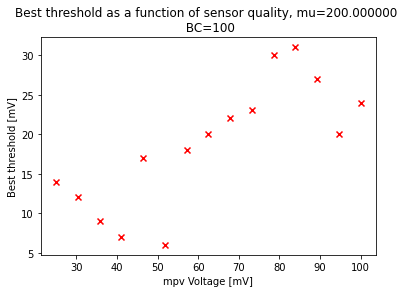

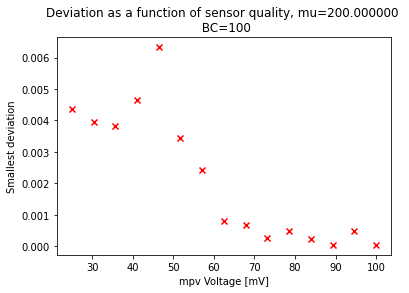

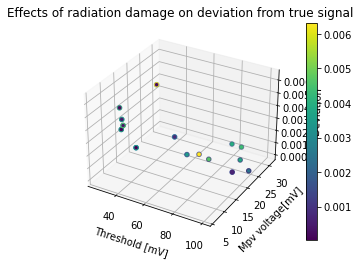

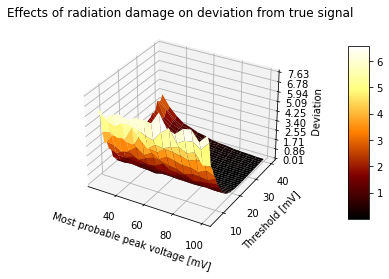

CPU time: 260.0758333206177 seconds


In [175]:
start_time = time.time()
min_mpv_peak = 25 #mV, the sensor at its worst state
max_mpv_peak = 100 #mV, new sensors
min_threshold = 5#mV
max_threshold = 40#mV
mpv_peak_array = np.linspace(min_mpv_peak,max_mpv_peak,15)
threshold_array = np.linspace(min_threshold,max_threshold,36)
iteration_peak = 0
start_time = time.time()
best_threshold_array = np.zeros (len(mpv_peak_array))
min_deviation_array = np.zeros(len(mpv_peak_array))
mpv_and_deviation = np.zeros((len(threshold_array), len(mpv_peak_array)))

for peak_value_step in mpv_peak_array:
    print("\nSimulations for mpv peak voltage %dmV\n" %peak_value_step)

    iteration = 0
    mean_values = []
    mean_values_with_std = []
    std_values = []
    val = []
    for threshold in threshold_array:
        true_signal, estimated_signal, dev_per_BC = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_value_step, peak_value_step)
        """Get the total deviation from the total simulated signals vs the expected signals.
            Returns both the total deviation as a positive number"""
           
        mean_values.append(abs(np.mean(dev_per_BC)))
        mean_values_with_std.append(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
        print ("Mean dev for threshold %f: %f" %(threshold, mean_values[iteration]))
        std_values.append(np.std(dev_per_BC))
        print ("Std for threshold %f: %f" %(threshold, std_values[iteration]))
        val.append (abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
            
        mpv_and_deviation[iteration][iteration_peak] = np.mean(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
            
        iteration = iteration+1
            
    best_threshold_array [iteration_peak] = find_best_threshold(mean_values)
    min_deviation_array [iteration_peak] = min(mean_values)
    print ("Best threshold for mpv peak voltage %dmV: %fmV" %(peak_value_step,best_threshold_array[iteration_peak]))
    print ("Minimum deviation for mpv peak voltage %d: %f" %(peak_value_step, min_deviation_array[iteration_peak]))
    #print("Deviation for mpv  %f: %f" %(peak_value_step, best_threshold_array[iteration_peak]))     
    iteration_peak = iteration_peak+1

plt.scatter(mpv_peak_array, best_threshold_array, marker = "x", color='red')
plt.title("Best threshold as a function of sensor quality, mu=%f \n BC=%d" %(mu, bunch_crossings))
plt.xlabel("mpv Voltage [mV]")
plt.ylabel("Best threshold [mV]")
plt.show()

plt.scatter(mpv_peak_array, min_deviation_array, marker = "x", color='red')
plt.title("Deviation as a function of sensor quality, mu=%f \n BC=%d" %(mu, bunch_crossings))
plt.xlabel("mpv Voltage [mV]")
plt.ylabel("Smallest deviation")
plt.show()

plt.show()

"""3D scatter plot with best thresholds and minimal deviation for that threshold"""
x = mpv_peak_array
y = best_threshold_array
z = min_deviation_array
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y ,z)
pnt3d=ax.scatter(x,y,z,c=z)
cbar=plt.colorbar(pnt3d)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Deviation')
ax.set_xlabel('Threshold [mV]')
ax.set_ylabel('Mpv voltage[mV]')
plt.show()

"""3D plot of deviation as a function of mpv and threshold"""

x = mpv_peak_array
y = threshold_array
z = np.array(mpv_and_deviation)

xv, yv = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot3d=ax.plot_surface(xv,yv,z,cmap='afmhot',)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Deviation')
ax.set_xlabel('Most probable peak voltage [mV]')
ax.set_ylabel('Threshold [mV]')
# Customize the z axis.
#ax.set_zlim(0, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.9, 0.2, 0.05, 0.6]) 
cb = plt.colorbar(plot3d, cax = cbaxes)  
plt.show()


print("CPU time: %s seconds" % (time.time() - start_time))

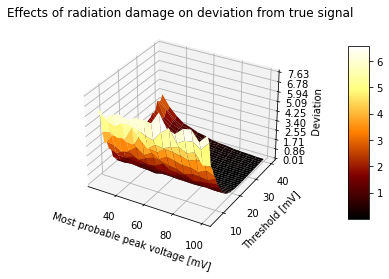

In [176]:
x = mpv_peak_array
y = threshold_array
z = np.array(mpv_and_deviation)

xv, yv = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot3d=ax.plot_surface(xv,yv,z,cmap='afmhot',)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Deviation')
ax.set_xlabel('Most probable peak voltage [mV]')
ax.set_ylabel('Threshold [mV]')
# Customize the z axis.
#ax.set_zlim(0, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.9, 0.2, 0.05, 0.6]) 
cb = plt.colorbar(plot3d, cax = cbaxes)  
plt.show()

snr = 20 in the beginning
snr = 5 later 

large time window multiple of 3.125

todo later: check non-linear approximation of nr of particles vs mu 

